In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F           # layers, activations and more
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from torch.jit import script, trace       # hybrid frontend decorator and tracing jit
from torch.autograd import Variable 
if torch.cuda.is_available(): 
    dev = "cuda:0" 
else: 
    dev = "cpu" 
device = torch.device(dev) 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from datetime import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt

# company = 'AAPL'

# # Define a start date and End Date
# start = dt(2010,1,1)

# # Read Stock Price Data 
# data = yf.download(company, start)
# data.keys()

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
mm = MinMaxScaler()

In [4]:
class Stock:
    def __init__(self, ticker, start_date, end_date=None):
        """
        Args:
          ticker: (str) - stock ticker symbol (e.g. "AAPL")
          start_date (str) (format: '01/30/2020') - date from which you wish data to start from 
          end_date (str) (format: '01/30/2020') - date you wish data to stop at (optional)
        """
        # retreive stock data from yahoo finance API
        start_date = dt.strptime(start_date, '%m/%d/%Y')
        end_date = dt.strptime(end_date, '%m/%d/%Y') if end_date else None
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.data = yf.download(ticker, start_date, end_date)
        self.feature_names = self.data.columns.values
        print(f"Dimensions of data are: {self.data.shape}")
        print(f"Column names are, in order, {self.feature_names}")
        
        # scale everything min max
        self.data = np.array(self.data)
        self.data = mm.fit_transform(self.data)
    
    def get_predictors_and_predictions(self, moving_window_size=20, batch_size=128):
        # get predictions and predictors
        self.predictors = self.data[:-moving_window_size]
        self.predictions = self.data[moving_window_size:]
        assert len(self.predictors) == len(self.predictions)
        
        # setup into batches of sequences
        num_batches = self.predictors.shape[0]//batch_size
        self.predictors = np.array_split(self.predictors, num_batches)
        self.predictions = np.array_split(self.predictions, num_batches)
        assert len(self.predictors) == len(self.predictions)
        
        return self.predictors, self.predictions
    
    def get_train_test(self, test_percentage=0.2):
        self.get_predictors_and_predictions()  
        x_train, x_test, y_train, y_test = train_test_split(self.predictors, self.predictions, test_size=test_percentage, shuffle=True)
        return x_train, x_test, y_train, y_test

In [5]:
apple = Stock("AAPL", "01/01/2010", "01/05/2023")
x_train, x_test, y_train, y_test = apple.get_train_test()
x_train = list(map(lambda x : x[:, [1,2,4,5]], x_train))
y_train = list(map(lambda x : x[:, -2], y_train))

[*********************100%***********************]  1 of 1 completed
Dimensions of data are: (3274, 6)
Column names are, in order, ['Open' 'High' 'Low' 'Close' 'Adj Close' 'Volume']


In [6]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=1):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.l1 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        
    def forward(self, data):
#         h_0 = torch.zeros(self.num_layers, data.shape[1], self.hidden_size) # hidden state -> long-term
#         c_0 = torch.zeros(self.num_layers, data.shape[1], self.hidden_size) # internal state -> short-term
        out, _ = self.lstm(data)
#         print(out, hn[-1])
        out = self.relu(out)
        out = self.l1(out)
        return out

In [12]:
num_epochs = 4000
lr = 0.001
input_size = 4 # number of features
hidden_size = 2 
num_layers = 1
output_size = 1
model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr) 

In [13]:
losses = np.array([])
indices = np.arange(num_epochs)
batch_size = min(map(lambda x : x.shape[0], x_train))
print(batch_size)
for i in range(len(x_train)):
    if x_train[i].shape[0] != batch_size:
        while(x_train[i].shape[0] != batch_size):
            x_train[i] = x_train[i][:batch_size, :]
            y_train[i] = y_train[i][:batch_size]

130


In [14]:
for epoch in tqdm(range(num_epochs)):
    running_loss = 0
    for x_batch, y_batch in zip(x_train, y_train):
        optimizer.zero_grad()
        out = model(torch.FloatTensor(x_batch).to(device))
        out = out.reshape(-1, 1)
        y_batch = y_batch.reshape(-1, 1)
        loss = loss_function(out, torch.FloatTensor(y_batch).to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    losses = np.append(losses, running_loss)
        

100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [04:38<00:00, 14.34it/s]


0.018562659510735102


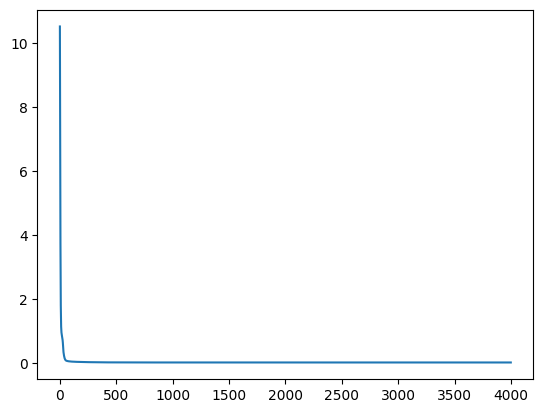

In [15]:
plt.plot(indices, losses)
print(losses[-1])

In [16]:
for i in range(len(x_test)):
    if x_test[i].shape[0] != batch_size:
        while(x_test[i].shape[0] != batch_size):
            x_test[i] = x_test[i][:batch_size, :]
            y_test[i] = y_test[i][:batch_size]
x_test_to_pass_in = list(map(lambda x : x[:, [1,2,4,5]], x_test))

In [32]:
predicted_output = []
for batch in x_test_to_pass_in:
    out = model(torch.FloatTensor(batch).to(device)).to("cpu").detach().numpy()
    predicted_output.append(out)
    
y_true = []
for i in range(len(x_test)):
    y_true.append(mm.inverse_transform(y_test[i]))
    predicted_output_copy = predicted_output[i]
    predicted_output[i] = np.zeros(x_test[i].shape)
    predicted_output[i][:, -2:-1] = predicted_output_copy
    predicted_output[i] = mm.inverse_transform(predicted_output[i])
    
y_true = np.array(y_true)
predicted_output = np.array(predicted_output)

In [33]:
y_true.shape

(5, 130, 6)

In [34]:
predicted_output.shape

(5, 130, 6)

In [35]:
y_true = y_true[:, :, -2].reshape(-1, 1)[:-20, :]
predicted_output = predicted_output[:, :, -2].reshape(-1, 1)[20:, :]

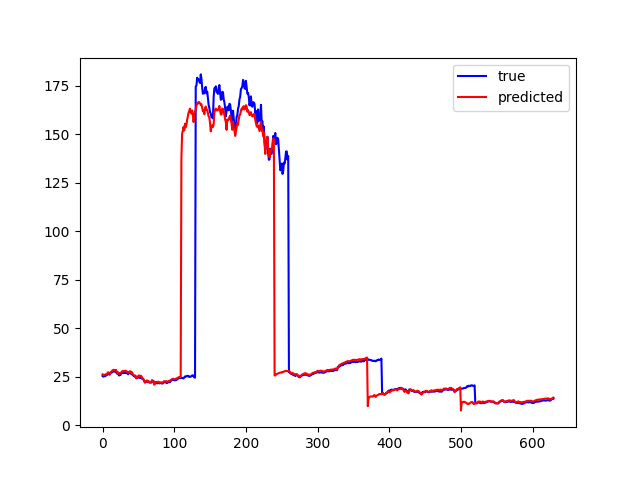

In [36]:
%matplotlib widget
plt.plot(y_true, color="blue", label="true")
plt.plot(predicted_output, color="red", label="predicted")
plt.legend()
plt.show()